# PDF page crop and merge with PyPDF2

Written with PyPDF2 version: 3.0.1

This notebook shows examples of how to crop and combine images in PDF format without loosing vectorial text. 

In [1]:
!pip install PyPDF2==3.0.1

In [2]:
import PyPDF2
PyPDF2.__version__

'3.0.1'

In [3]:
from PyPDF2 import PdfReader, PdfWriter, PageObject, Transformation
from PyPDF2.generic import RectangleObject, PdfObject

In [4]:
#other libraries to show the final pdfs in the examples
!pip install pdf2image 
!pip install matplotlib

In [5]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

## 1. Show original PDF image 

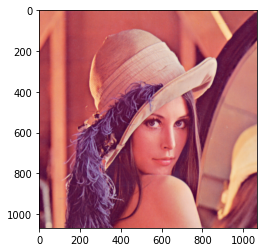

In [6]:
#Original pdf 
convert_from_path('example.pdf')[0].save('example.png')
img = mpimg.imread('example.png')
plt.imshow(img)

## 2. Resize PDF image

In [7]:
def pdf_resize(pdf_path, ratio, output_file_name=None): 
    """
    Reads, resizes and saves a PDF page or image 
    
    Parameters
    ----------
    pdf_path: str
        Path of the PDF in file system
    ratio: float
        Numerical value between 0 and 1. Resize ratio in terms of total size percentage. 
    output_file_name: str, default=None
        Path of the final PDF in file system. If None, output_fil_name=pdf_path (overwrites file).
    """
    if ratio<0 or ratio>1: 
        raise Exception('ratio must be a numerical value between 0 and 1.')
    
    #read pdf page
    reader = PdfReader(open(pdf_path, 'rb'))
    page = reader.pages[0]
    
    #resize
    page.scale_by(ratio)
    
    #save new pdf
    writer = PdfWriter()
    writer.add_page(page)
    if output_file_name: 
        file_name = output_file_name
    else: 
        file_name = pdf_path
    with open(file_name, 'wb') as f:
        writer.write(f)
    

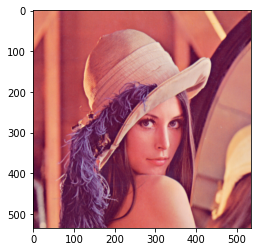

In [8]:
#Resized pdf
pdf_resize('example.pdf', ratio=0.5, output_file_name='example_resize.pdf')
convert_from_path('example_resize.pdf')[0].save('example_resize.png')
img = mpimg.imread('example_resize.png')
plt.imshow(img)

## 3. Crop PDF image 

In [9]:
def pdf_crop(pdf_path, upper=0, lower=0, left=0, right=0, output_file_name=None): 
    """
    Reads, crops and saves a PDF page or image
    
    Parameters
    ----------
    pdf_path: str
        Path of the PDF in file system
    upper: float, default=0
        Numerical value between 0 and 1. Crop value of the upper margin in terms of total height percentage. 
    lower: float, default=0
        Numerical value between 0 and 1. Crop value of the lower margin in terms of total height percentage. 
    left: float, default=0
        Numerical value between 0 and 1. Crop value of the left margin in terms of total width percentage. 
    right: float, default=0
        Numerical value between 0 and 1. Crop value of the right margin in terms of total width percentage. 
    output_file_name: str, default=None
        Path of the final PDF in file system. If None, output_file_name=pdf_path (overwrites file).
    """
    if upper<0 or upper>1 or lower<0 or lower>1 or left<0 or left>1 or right<0 or right>1: 
        raise Exception('lower, upper, left and right must be numerical values between 0 and 1.')
    
    #read pdf page
    reader = PdfReader(open(pdf_path, 'rb'))
    page = reader.pages[0]
    
    #calculate new margins 
    _, y = page.cropbox.upper_left
    x,_ = page.cropbox.lower_right
    upper = upper*float(page.mediabox.height)
    lower = lower*float(page.mediabox.height)
    left = left*float(page.mediabox.width)
    right = right*float(page.mediabox.width)
    
    #apply new margins 
    page.add_transformation(Transformation().translate(-left, -lower))
    new_mediabox = RectangleObject((0, 0, float(page.mediabox.width)-right-left, float(page.mediabox.height)-upper-lower))
    new_trimbox = RectangleObject((0, 0, float(page.mediabox.width)-right-left, float(page.mediabox.height)-upper-lower))
    page.mediabox = new_mediabox
    page.trimbox = new_trimbox
    new_upper_left = (0, float(y)-upper-lower)
    new_lower_right = (float(x)-right-left, 0)
    page.cropbox.upper_left = new_upper_left
    page.cropbox.lower_right = new_lower_right

    #save new pdf
    writer = PdfWriter()
    writer.add_page(page)
    if output_file_name: 
        file_name = output_file_name
    else: 
        file_name = pdf_path
    with open(file_name, 'wb') as f:
        writer.write(f)
    

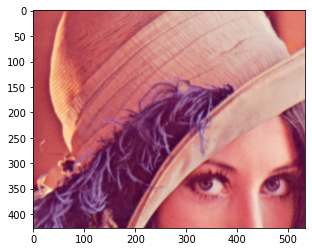

In [10]:
#Cropped pdf
pdf_crop('example.pdf', left=0.2, right=0.3, upper=0.2, lower=0.4, output_file_name='example_crop.pdf')
convert_from_path('example_crop.pdf')[0].save('example_crop.png')
img = mpimg.imread('example_crop.png')
plt.imshow(img)

## 3. Merge PDF images in one page 

In [11]:
def pdf_combine(pdf_path_list, orientation='horizontal', alignment='center', output_file_name='combination.pdf'):
    """
    Reads a list of PDF pages, combines them horizontally or vertically and saves a PDF page or image. 
    
    Parameters
    ----------
    pdf_path_list: list of str
        List with the paths of the PDFs in file system
    orientation: str
        If orientation='horizontal' PDFs are combined horizontally. If orientation='vertical' PDFs are 
        combined vertically. 
    alignment: str, default='center'
        If orientation='horizontal', alignment may be 'center', 'up' or 'down'. If orientation ='vertical', 
        alignment may be 'center', 'left' or 'right'. 
    output_file_name: str, default='combination.pdf'
        Path of the final PDF in file system.
    """
    #calculate mediabox size for final page 
    pages = []
    final_width = 0
    final_height = 0
    max_width = 0
    max_height = 0
    for pdf in pdf_path_list:
        reader = PdfReader(open(pdf, 'rb'))
        page = reader.pages[0]
        pages.append(page)
        
        if orientation == 'horizontal': 
            final_width+= float(page.mediabox.width)
            if float(page.mediabox.height)>max_height: 
                max_height = float(page.mediabox.height)
        else: 
            final_height+= float(page.mediabox.height)
            if float(page.mediabox.width)>max_width: 
                max_width = float(page.mediabox.width)
        
    #create final page 
    if orientation == 'horizontal': 
        final_page = PageObject.create_blank_page(None, final_width, max_height)
    else: 
        final_page = PageObject.create_blank_page(None, max_width, final_height)
        
    for i_page in range(len(pages)-1, -1, -1): #pages in reverse order
        
        if orientation == 'horizontal': 
            if alignment == 'center': 
                aux_page = PageObject.create_blank_page(None, pages[i_page].mediabox.width, max_height)
                aux_page.merge_page(pages[i_page])
                ty = max_height/2 - float(pages[i_page].mediabox.height)/2
                aux_page.add_transformation(Transformation().translate(0, ty))
            elif alignment == 'up': 
                aux_page = PageObject.create_blank_page(None, pages[i_page].mediabox.width, max_height)
                aux_page.merge_page(pages[i_page])
                ty = max_height- float(pages[i_page].mediabox.height)
                aux_page.add_transformation(Transformation().translate(0, ty))
            elif alignment == 'down':
                aux_page = pages[i_page]
            else: 
                raise Exception("alignment must be 'center', 'up' or 'down' when orientation is 'horizontal'.")
        elif orientation == 'vertical': 
            if alignment == 'center':
                aux_page = PageObject.create_blank_page(None, max_width, pages[i_page].mediabox.height)
                aux_page.merge_page(pages[i_page])
                tx = max_width/2 - float(pages[i_page].mediabox.width)/2
                aux_page.add_transformation(Transformation().translate(tx, 0))
            elif alignment == 'right': 
                aux_page = PageObject.create_blank_page(None, max_width, pages[i_page].mediabox.height)
                aux_page.merge_page(pages[i_page])
                tx = max_width - float(pages[i_page].mediabox.width)
                aux_page.add_transformation(Transformation().translate(tx, 0))
            elif alignment == 'left': 
                aux_page = pages[i_page]
            else: 
                raise Exception("alignment must be 'center', 'left' or 'right' when orientation is 'vertical'.")
        else: 
            raise Exception("alignment must be 'horizontal' or 'vertical'.")
        
        
        final_page.merge_page(aux_page)

        if i_page != 0: 
            if orientation == 'horizontal': 
                tx = float(pages[i_page-1].mediabox.width)
                ty = 0
            else: 
                tx = 0
                ty = float(pages[i_page-1].mediabox.height)
            final_page.add_transformation(Transformation().translate(tx, ty))
    
    #save final page 
    writer = PdfWriter()
    writer.add_page(final_page)
    with open(output_file_name, 'wb') as f:
        writer.write(f)

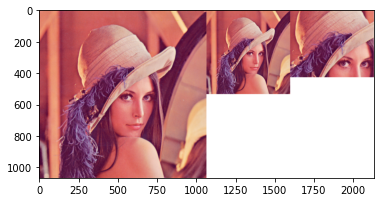

In [12]:
#orientation='horizontal', alighment='up'
pdf_paths = ['example.pdf', 'example_resize.pdf', 'example_crop.pdf']
pdf_combine(pdf_paths, orientation='horizontal', alignment='up', output_file_name='horizontal_up_combination.pdf')
convert_from_path('horizontal_up_combination.pdf')[0].save('horizontal_up_combination.png')
img = mpimg.imread('horizontal_up_combination.png')
plt.imshow(img)

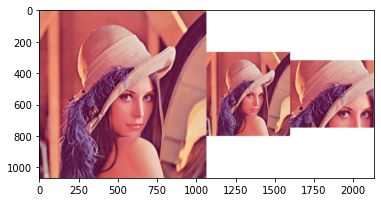

In [13]:
#orientation='horizontal', alighment='center'
pdf_paths = ['example.pdf', 'example_resize.pdf', 'example_crop.pdf']
pdf_combine(pdf_paths, orientation='horizontal', alignment='center', output_file_name='horizontal_center_combination.pdf')
convert_from_path('horizontal_center_combination.pdf')[0].save('horizontal_center_combination.png')
img = mpimg.imread('horizontal_center_combination.png')
plt.imshow(img)

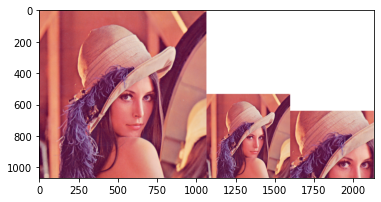

In [14]:
#orientation='horizontal', alighment='down'
pdf_paths = ['example.pdf', 'example_resize.pdf', 'example_crop.pdf']
pdf_combine(pdf_paths, orientation='horizontal', alignment='down', output_file_name='horizontal_down_combination.pdf')
convert_from_path('horizontal_down_combination.pdf')[0].save('horizontal_down_combination.png')
img = mpimg.imread('horizontal_down_combination.png')
plt.imshow(img)

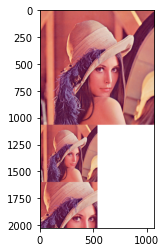

In [15]:
#orientation='vertical', alignment='left'
pdf_paths = reversed(['example.pdf', 'example_resize.pdf', 'example_crop.pdf'])
pdf_combine(pdf_paths, orientation='vertical', alignment='left', output_file_name='vertical_left_combination.pdf')
convert_from_path('vertical_left_combination.pdf')[0].save('vertical_left_combination.png')
img = mpimg.imread('vertical_left_combination.png')
plt.imshow(img)

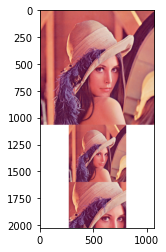

In [16]:
#orientation='vertical', alignment='center'
pdf_paths = reversed(['example.pdf', 'example_resize.pdf', 'example_crop.pdf'])
pdf_combine(pdf_paths, orientation='vertical', alignment='center', output_file_name='vertical_center_combination.pdf')
convert_from_path('vertical_center_combination.pdf')[0].save('vertical_center_combination.png')
img = mpimg.imread('vertical_center_combination.png')
plt.imshow(img)

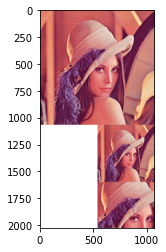

In [17]:
#orientation='vertical', alignment='right'
pdf_paths = reversed(['example.pdf', 'example_resize.pdf', 'example_crop.pdf'])
pdf_combine(pdf_paths, orientation='vertical', alignment='right', output_file_name='vertical_right_combination.pdf')
convert_from_path('vertical_right_combination.pdf')[0].save('vertical_right_combination.png')
img = mpimg.imread('vertical_right_combination.png')
plt.imshow(img)